In [1]:
# imports
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io as io
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [3]:
# directory paths
cur_dir = os.getcwd()
# load_dataset_dir = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(cur_dir, 'drive'), 'MyDrive'), 'Coursework'), 'Current Semester'), 'ECSE 552'), 'ECSE 552 Project'), 'load_dataset')
# load_dataset_dir = os.path.join(os.path.join(os.path.join(os.path.join(cur_dir, 'drive'), 'MyDrive'), 'ECSE 552 Project'), 'load_dataset')
load_dataset_dir = os.path.join(cur_dir, 'load_dataset')
dataset_dir = os.path.join(load_dataset_dir, 'dataset')
train_set_dir = os.path.join(dataset_dir, 'train')
test_set_dir = os.path.join(dataset_dir, 'test')

In [4]:
# dataframes holding the label image label info
train_frame = pd.read_csv(os.path.join(dataset_dir, 'train_labels.csv'))
test_frame = pd.read_csv(os.path.join(dataset_dir, 'test_labels.csv'))

In [5]:
# extract filenames and labels into arrays
train_img_names = train_frame.iloc[0:, 0]
train_labels = np.asarray(train_frame.iloc[0:, 1])

test_img_names = test_frame.iloc[0:, 0]
test_labels = np.asarray(test_frame.iloc[0:, 1])

healthy: 18468, diseased: 41875


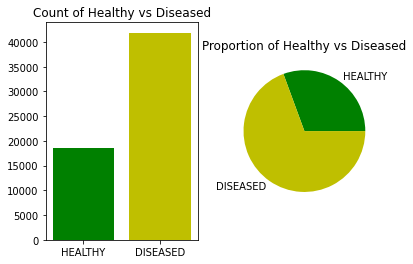

In [6]:
# visualize the number of healthy vs number of diseased samples in train set
num_healthy = sum(train_labels)
num_diseased = len(train_labels) - num_healthy
print('healthy: {}, diseased: {}'.format(num_healthy, num_diseased))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(['HEALTHY', 'DISEASED'], [num_healthy, num_diseased], color=['g', 'y'])
ax1.set_title('Count of Healthy vs Diseased')

ax2.pie([num_healthy, num_diseased], labels=['HEALTHY', 'DISEASED'], colors=['g', 'y'])
ax2.set_title('Proportion of Healthy vs Diseased')

plt.show()

healthy: 3496, diseased: 3159


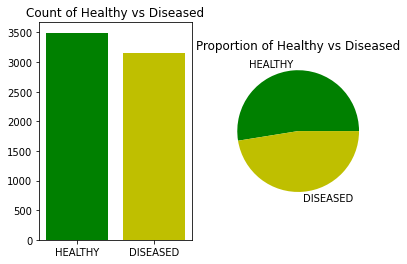

In [7]:
# same as above, but for test set
num_healthy = sum(test_labels)
num_diseased = len(test_labels) - num_healthy
print('healthy: {}, diseased: {}'.format(num_healthy, num_diseased))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(['HEALTHY', 'DISEASED'], [num_healthy, num_diseased], color=['g', 'y'])
ax1.set_title('Count of Healthy vs Diseased')

ax2.pie([num_healthy, num_diseased], labels=['HEALTHY', 'DISEASED'], colors=['g', 'y'])
ax2.set_title('Proportion of Healthy vs Diseased')

plt.show()

In [8]:
def show_image(image, label):
  """Show image with label"""
  plt.imshow(image.permute(1,2,0)) # reshape to have channels in last dimension to satisfy plt
  plt.title('label={}'.format(label))

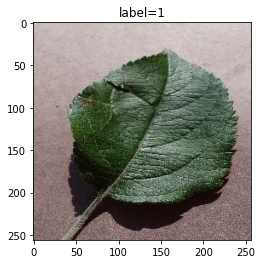

In [9]:
plt.figure()
show_image(io.read_image(os.path.join(train_set_dir, train_img_names[0]), mode=io.ImageReadMode.RGB), train_labels[0])
plt.show()

In [10]:
transform = T.Grayscale()

In [30]:
class LeafDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.label_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.label_frame)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label_frame.iloc[idx, 0])
        img = io.read_image(img_name, mode=io.ImageReadMode.RGB)
        label = torch.tensor([self.label_frame.iloc[idx, 1]])

        if self.transform:
          img = self.transform(img)

        # sample = {'image': img, 'label': label}

        # return sample

        return img, label

0 torch.Size([3, 256, 256]) tensor([1])
1 torch.Size([3, 256, 256]) tensor([1])
2 torch.Size([3, 256, 256]) tensor([1])
3 torch.Size([3, 256, 256]) tensor([1])


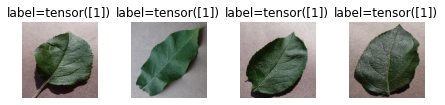

In [31]:
# construct training set
train_dataset = LeafDataset(csv_file=os.path.join(dataset_dir, 'train_labels.csv'), root_dir=train_set_dir)

# display first 4 samples from train set
fig = plt.figure()
for i in range(len(train_dataset)):
  # sample = train_dataset[i]
  img, label = train_dataset[i]

  # print(i, sample['image'].shape, sample['label'])
  print(i, img.shape, label)

  ax = plt.subplot(1, 4, i+1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  # show_image(**sample)
  show_image(img, label)

  if i == 3:
    plt.show()
    break

In [33]:
# sample datasets for testing purposes
train_set, val_set=torch.utils.data.random_split(train_dataset, [40000,20343])
sample_train_set, sample_val_set=torch.utils.data.random_split(train_set, [28000,12000])

sample_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=0)

In [34]:
for i, sample in enumerate(sample_dataloader):
  img, label = sample
  print(i, img.shape, label.shape)

0 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
1 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
2 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
3 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
4 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
5 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
6 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
7 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
8 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
9 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
10 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
11 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
12 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
13 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
14 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
15 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
16 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
17 torch.Size([128, 3, 256, 256]) torch.Size([128, 1])
18 torch.Size([128, 

# Twin Matching NN
## Key idea:
- Train matching NN to detect whether two input images have the same binary class (healthy vs diseased) or not.
- To classify an unkown image, run it through the trained NN with a known image (or possibly one of each class, maybe more) to see if the NN says it is the same class as the known image.

## Steps:
1. Training stage
  1. Create two DataLoaders from the same training set.
  2. For every epoch:
    1. For every sample of two images (one from each DataLoader):
      1. Set y as y1 == y2 (i.e., are the two images of the same class?)
      2. Feed both images into model to obtain result, y_hat
      3. Use y and y_hat to calculate loss, via loss function
      4. Backprop loss
      5. Step optimizer



In [35]:
# creating matching neural networks
class MatchingNetwork(nn.Module):
  def __init__(self, input_size):
    super(MatchingNetwork, self).__init__()
    
    # conv -> (6, 252, 252)
    # pool -> (6, 84, 84)
    self.layer1 = torch.nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
      nn.MaxPool2d(kernel_size=3, stride=3),
      nn.ReLU())
    
    # conv -> (12, 80, 80)
    # pool -> (12, 40, 40)
    self.layer2 = torch.nn.Sequential(
      nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.ReLU())
    
    # conv -> (24, 38, 38)
    # pool -> (24, 19, 19)
    self.layer3 = torch.nn.Sequential(
      nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.ReLU())
    
    # fcl -> (1, 64)
    self.layer4 = torch.nn.Sequential(
      nn.Linear(24 * 19 * 19, 64),
      nn.ReLU(),
      nn.Dropout(p=0.1))
    
    # fcl -> (1, 32)
    self.layer5 = torch.nn.Sequential(
      nn.Linear(64, 32),
      nn.ReLU())
    
    # # fcl -> (1, 32)
    # self.layer6 = torch.nn.Sequential(
    #   nn.Linear(64, 32),
    #   nn.ReLU())

    # fcl -> (1, 1)
    self.out = nn.Linear(64, 1)
    
  def forward(self, x1, x2):
    x1 = self.layer1(x1)
    x1 = self.layer2(x1)
    x1 = self.layer3(x1)
    x1 = x1.view(-1, 24 * 19 * 19)
    x1 = self.layer4(x1)
    x1 = self.layer5(x1)
    # x1 = self.layer6(x1)

    x2 = self.layer1(x2)
    x2 = self.layer2(x2)
    x2 = self.layer3(x2)
    x2 = x2.view(-1, 24 * 19 * 19)
    x2 = self.layer4(x2)
    x2 = self.layer5(x2)
    # x2 = self.layer6(x2)

    return self.out(torch.cat([x1,x2], -1))

In [36]:
# actual dataloaders for the twin network (sample train set for dev purposes)
train_dl_1 = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
train_dl_2 = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

val_dl_1 = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)
val_dl_2 = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
# training loop
def train(model, train_dl_1, train_dl_2, val_dl_1, val_dl_2, n_epoch, loss_func, optimizer):
  train_acc_list=[]
  train_loss_list=[]
  val_acc_list=[]
  val_loss_list=[]
  # train for n epochs
  for i in range(1, n_epoch+1):
    model.train()
    train_loss = 0
    train_acc = 0
    # iterate through each batch of both DataLoaders
    for batch_idx, (data1, data2) in enumerate(zip(train_dl_1, train_dl_2)): 
      x1 = data1[0].to(device).float() # image
      x1 = transform(x1)
      y1 = data1[1].to(device) # label
  
      x2 = data2[0].to(device).float() # image
      x2 = transform(x2)
      y2 = data2[1].to(device) # label
                  
      # set y to be whether both images are of same class
      y = ((y1 == y2)*1.0).view(-1,1)
      y = torch.squeeze(y,1)

      # reset the gradients
      optimizer.zero_grad() 
  
      # flatten the images before feeding into model for output
      y_hat = (model(x1, x2)).view(-1,1)
      y_hat = torch.squeeze(y_hat, 1)

      # calculate batch loss and update weights
      loss = loss_func(y_hat, y)
      
      loss.backward() 
      optimizer.step() # weight update
      
      train_loss += loss.detach().cpu().numpy()
      train_acc += ((torch.sigmoid(y_hat)>0.5)*1 == y).detach().cpu().numpy().mean()

    train_loss = train_loss/len(train_dl_1)
    train_acc = train_acc/len(train_dl_1)
    # print('epoch {}, train loss {}, train acc {}'.format(i, train_loss, train_acc))

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    # evaluate
    model.eval()
    val_loss = 0
    val_acc = 0
    correct_pred = 0
    with torch.no_grad():
      for batch_idx, (data1, data2) in enumerate(zip(val_dl_1, val_dl_2)):
        x1 = data1[0].to(device).float() # image
        x1 = transform(x1)
        y1 = data1[1].to(device) # label
  
        x2 = data2[0].to(device).float() # image
        x2 = transform(x2)
        y2 = data2[1].to(device) # label

        # set y to be whether both images are of same class
        y = ((y1 == y2)*1.0).view(-1,1)
        y = torch.squeeze(y,1)

        # flatten the images before feeding into model for output
        y_hat = model(x1, x2)
        y_hat = torch.squeeze(y_hat, 1)

        # calculate validation loss
        loss = loss_func(y_hat, y)
        
        val_loss += loss.detach().cpu().numpy()
        val_acc += ((torch.sigmoid(y_hat)>0.5)*1 == y).detach().cpu().numpy().mean()       
      
      val_loss = val_loss/len(val_dl_1)
      val_acc = val_acc/len(val_dl_1)

      val_acc_list.append(val_acc)
      val_loss_list.append(val_loss)
      # print('epoch {}, val loss {}, val acc {} '.format(i, val_loss, val_acc))
    
    print('epoch {}, train loss {}, train acc {}, val loss {}, val acc {}'.format(i, train_loss, train_acc, val_loss, val_acc))    
    
  loss_iteration(train_loss_list,val_loss_list)
  acc_iteration(train_acc_list,val_acc_list)
  return model

In [38]:
def loss_iteration(train_loss,val_loss):
  plt.figure(figsize=(10,8))
  plt.plot(train_loss, lw=4, label='Training Loss')
  plt.plot(val_loss, lw=4, label='Validation Loss')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epochs')
  plt.legend()

In [39]:
def acc_iteration(train_acc,val_acc):
  plt.figure(figsize=(10,8))
  plt.plot(train_acc, lw=4, label='Training Accuracy')
  plt.plot(val_acc, lw=4, label='Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs Epochs')
  plt.legend()

epoch 1, train loss 0.6883875718131994, train acc 0.593325678913738, val loss 0.6488722356610328, val acc 0.6183163713598647
epoch 2, train loss 0.6387268767570154, train acc 0.646216054313099, val loss 0.6409421484425383, val acc 0.6339764679456689
epoch 3, train loss 0.629130642634992, train acc 0.6655101837060703, val loss 0.6307791763881467, val acc 0.6425743056656625
epoch 4, train loss 0.6259896254387146, train acc 0.6678065095846646, val loss 0.6282660440079071, val acc 0.6499817497753818
epoch 5, train loss 0.6174413756059762, train acc 0.6789137380191693, val loss 0.62095079182079, val acc 0.6769801080809683
epoch 6, train loss 0.612886672774062, train acc 0.6835063897763578, val loss 0.6387239016077053, val acc 0.7055619417578353
epoch 7, train loss 0.6117861971687585, train acc 0.6915684904153354, val loss 0.6108890187065557, val acc 0.6917132419005337
epoch 8, train loss 0.605886856587931, train acc 0.7007537939297125, val loss 0.6134231611617706, val acc 0.6855065139263252

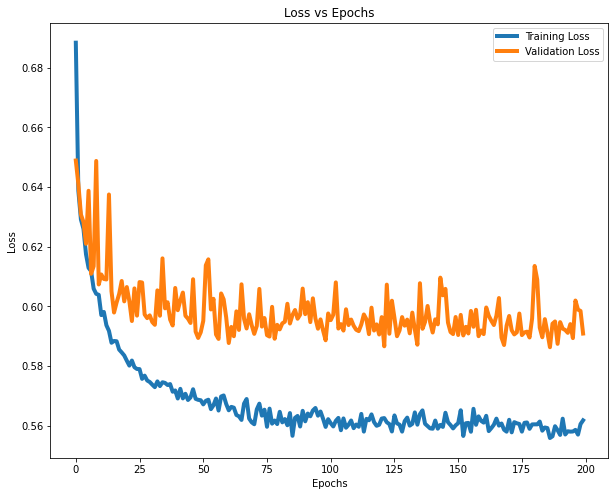

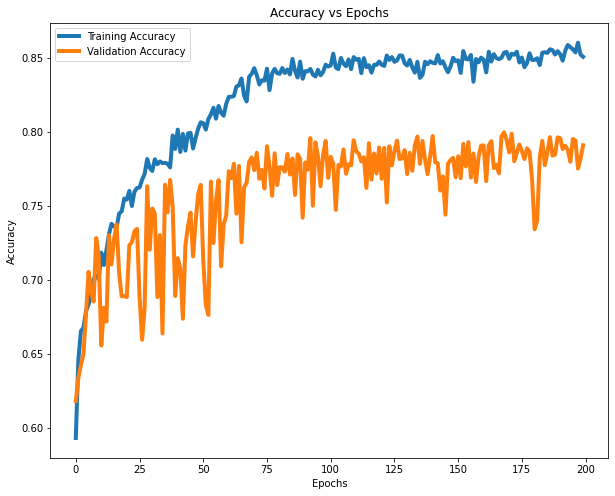

In [44]:
# construct and train model
model_v1 = MatchingNetwork(256*256)
model_v1 = model_v1.to(device)
bce = nn.BCEWithLogitsLoss()
bce_loss = lambda y_hat, y: bce(y_hat.view(-1,1),y.view(-1,1))

optimizer = torch.optim.Adam(model_v1.parameters(), lr=1e-3,weight_decay=1e-4)

model_v1 = train(model_v1, train_dl_1, train_dl_2, val_dl_1, val_dl_2, 200, bce, optimizer)

In [45]:
torch.save({
    'epoch': 200,
    'model_state_dict': model_v1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_func': bce
}, os.path.join(cur_dir, 'grey-cnn-model.pth'))

In [46]:
checkpoint = torch.load(os.path.join(cur_dir, 'grey-cnn-model.pth'))

In [47]:
checkpoint

{'epoch': 200,
 'model_state_dict': OrderedDict([('layer1.0.weight',
               tensor([[[[ 0.3086,  0.0093, -0.1659, -0.1517, -0.1592],
                         [-0.0608, -0.2832,  0.3520,  0.2379, -0.0321],
                         [-0.3452, -0.0998, -0.3704,  0.3221,  0.0035],
                         [ 0.2492, -0.2707,  0.4775, -0.4781,  0.0654],
                         [-0.1496,  0.0903, -0.2632,  0.2040,  0.0924]]],
               
               
                       [[[-0.1663, -0.3381, -0.1644,  0.1181, -0.2997],
                         [-0.2671,  0.0544, -0.0323,  0.0920, -0.1676],
                         [-0.0014,  0.0108, -0.1700, -0.0469,  0.1714],
                         [ 0.1375,  0.0721,  0.1535,  0.1616,  0.0584],
                         [ 0.0652,  0.1942,  0.2666,  0.1924,  0.0008]]],
               
               
                       [[[ 0.0234, -0.0125,  0.1188,  0.1914,  0.1546],
                         [-0.5757, -0.2436, -0.0051, -0.0600,  0.0604],